Null values per column:
 No.                    0
longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        12
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        7
dtype: int64

Total number of null values: 19

Rows with null values:
     No.  longitude  latitude  housing_median_age  total_rooms  \
72    73    -122.08     37.88                  26         2947   
93    94    -119.80     36.75                  46         2625   
98    99    -119.82     36.81                  25         3305   
168  169    -118.28     34.25                  29         2559   
236  237    -118.38     34.05                  49          702   
548  549    -117.87     33.83                  27         2287   
585  586    -121.26     38.74                  22         7173   
595  596    -121.04     39.00                  21         4059   
603   94    -119.80     36.75       

<Figure size 1500x900 with 0 Axes>

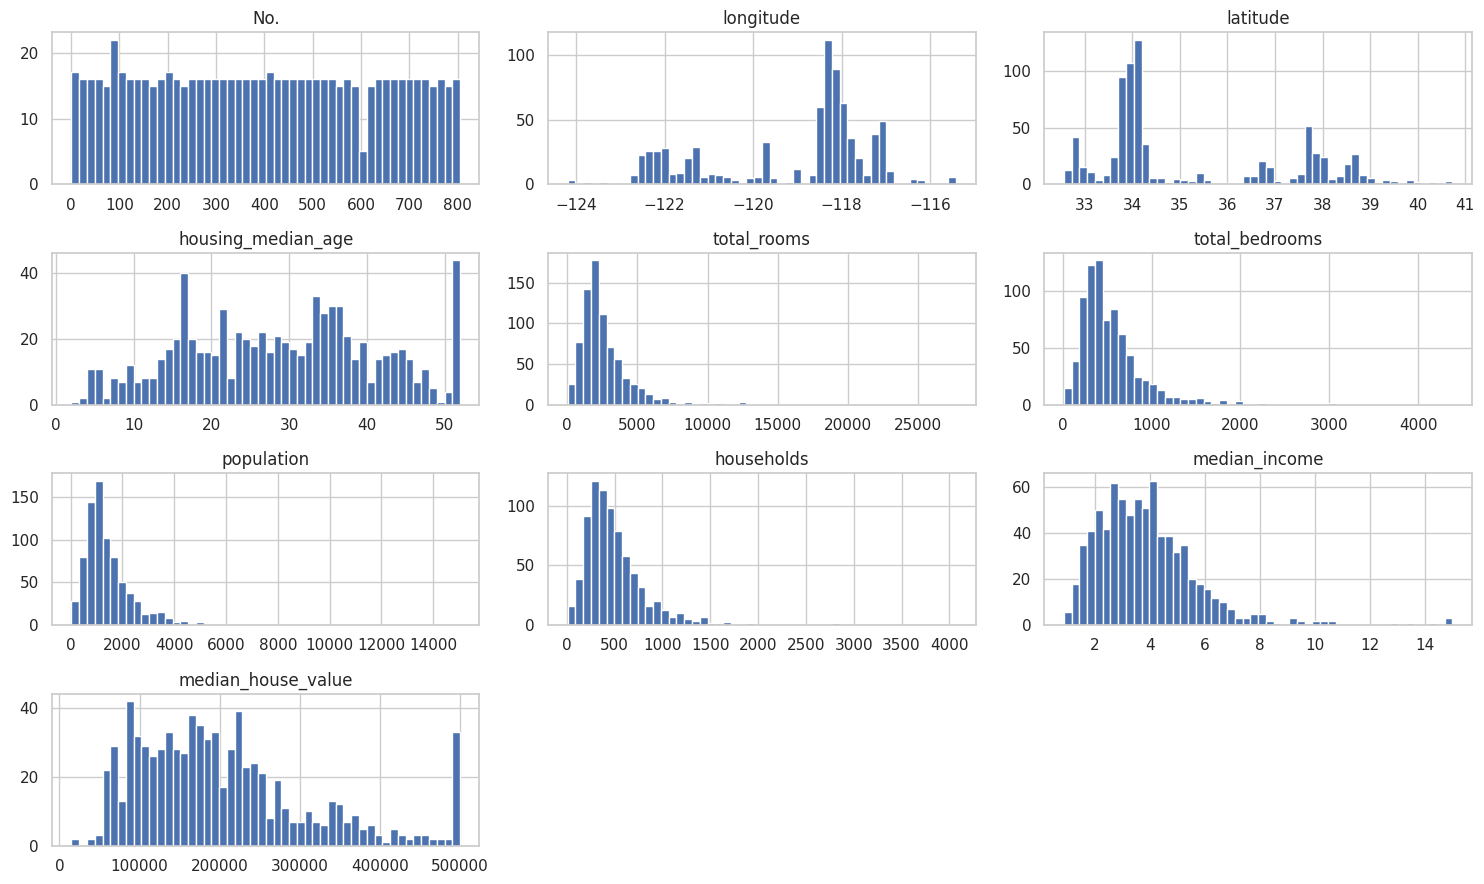

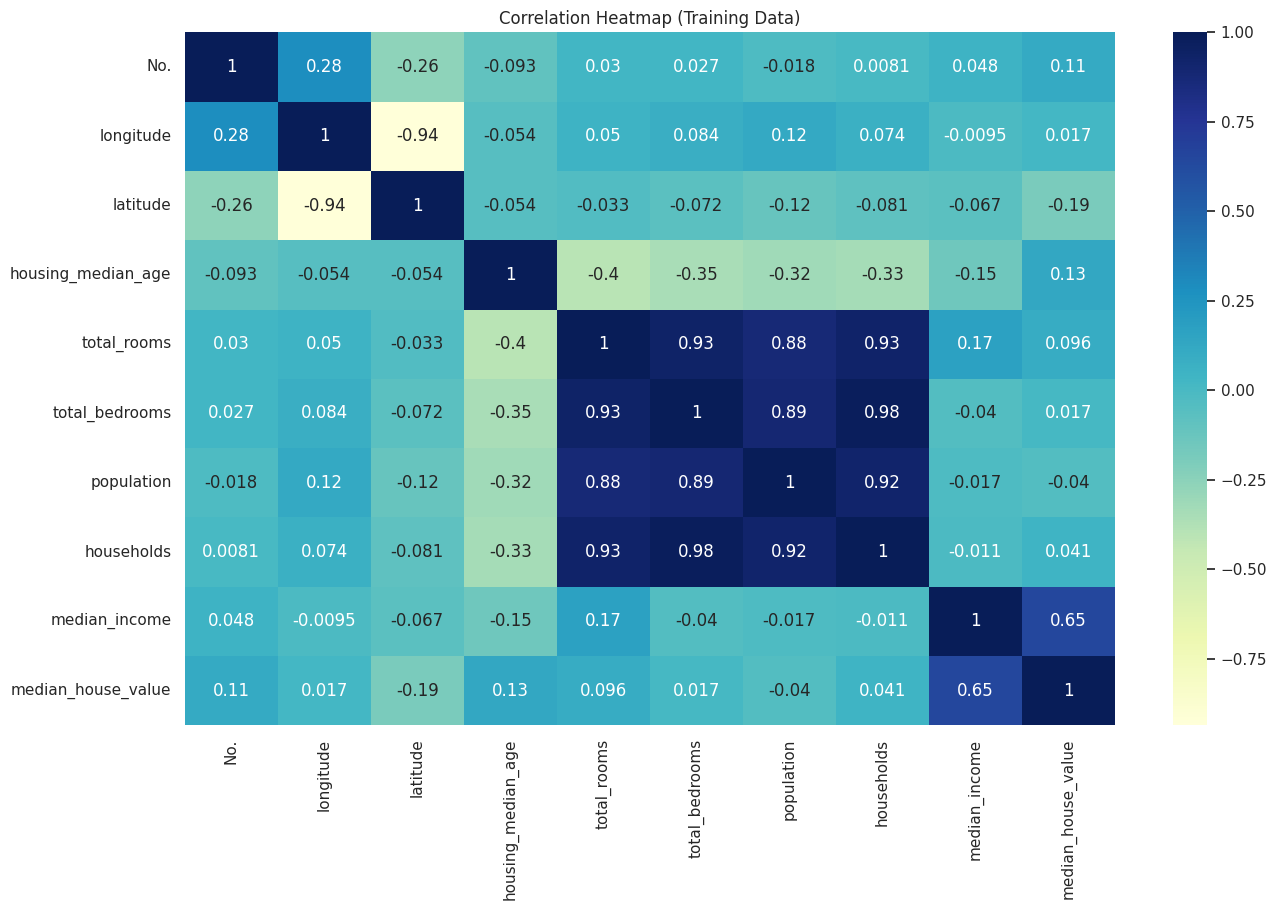

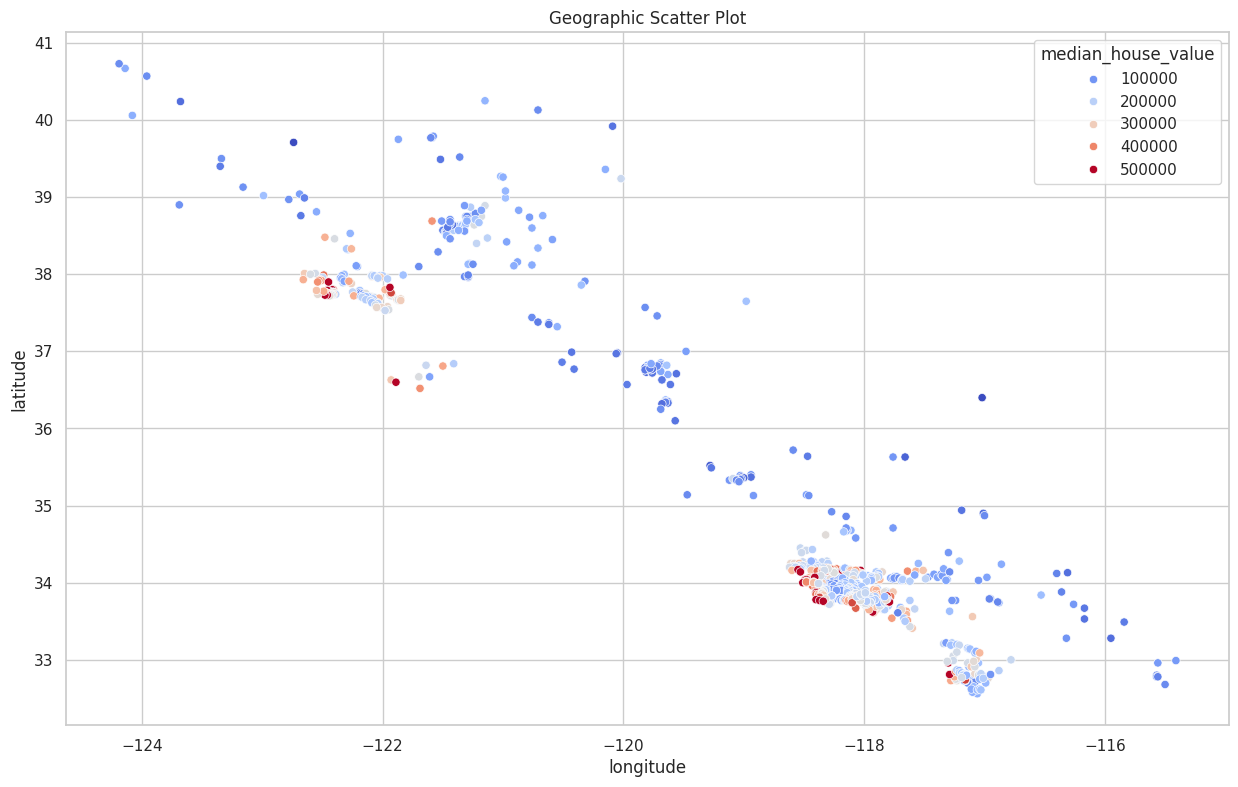


Ocean Proximity Value Counts (Training):
ocean_proximity
<1H OCEAN     368
INLAND        258
NEAR OCEAN     84
NEAR BAY       81
Name: count, dtype: int64


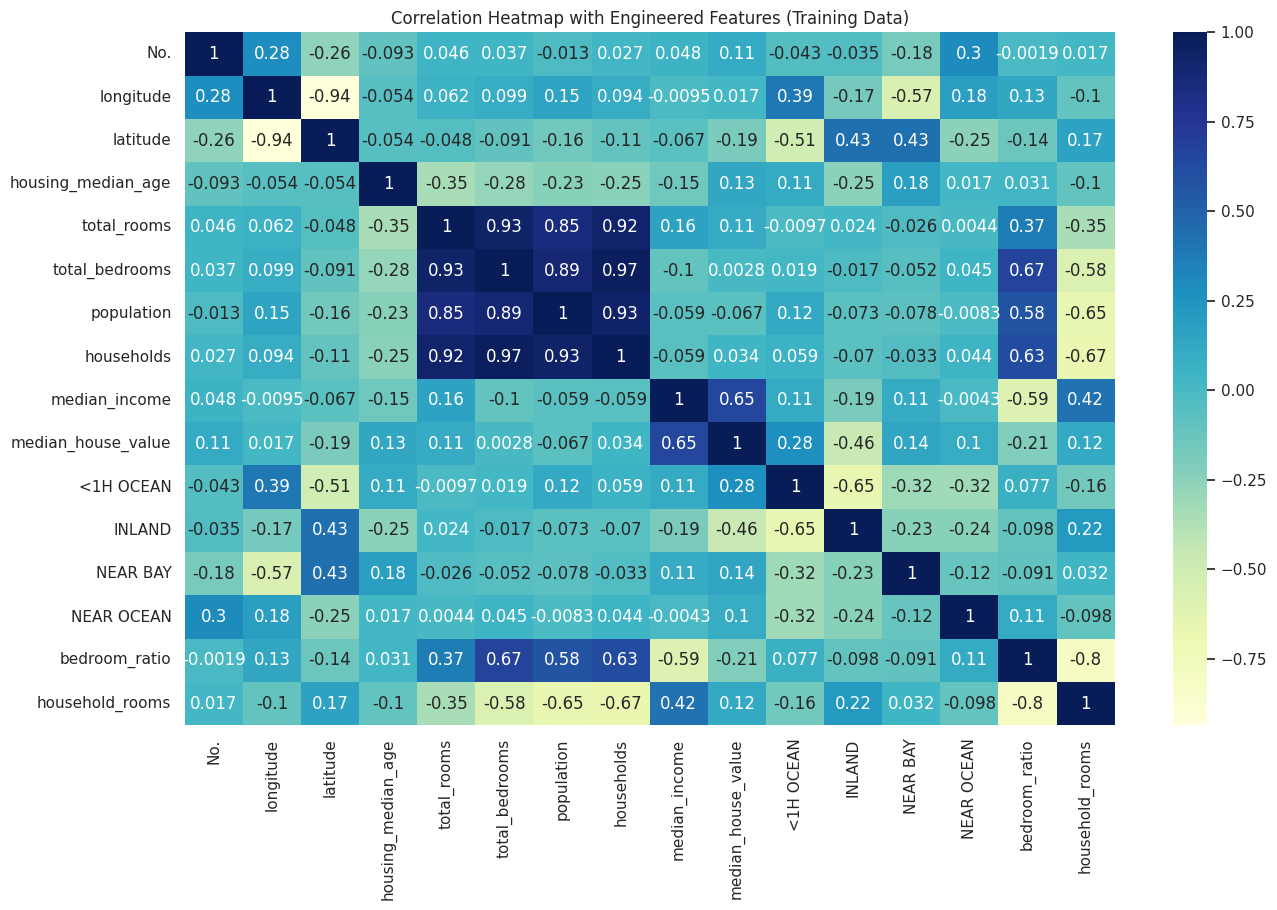


Linear Regression Evaluation:
Mean Squared Error (MSE): 5668496699.90
Root Mean Squared Error (RMSE): 75289.42
R-squared (R²): 0.63

Grid Search Best Estimator (Random Forest):
RandomForestRegressor(max_features=8, min_samples_split=4)
Test Score (R²): 0.68

Model Comparison:
Model                MSE        RMSE       R²        
Decision Tree        9643419915.85 98200.92   0.37      
Random Forest        5071088640.09 71211.58   0.67      
Gradient Boosting    4923415496.81 70167.05   0.68      

Linear Regression Reference:
Linear Regression    5668496699.90 75289.42   0.63      

Final Grid Search Best Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE (Training CV): 72866.00


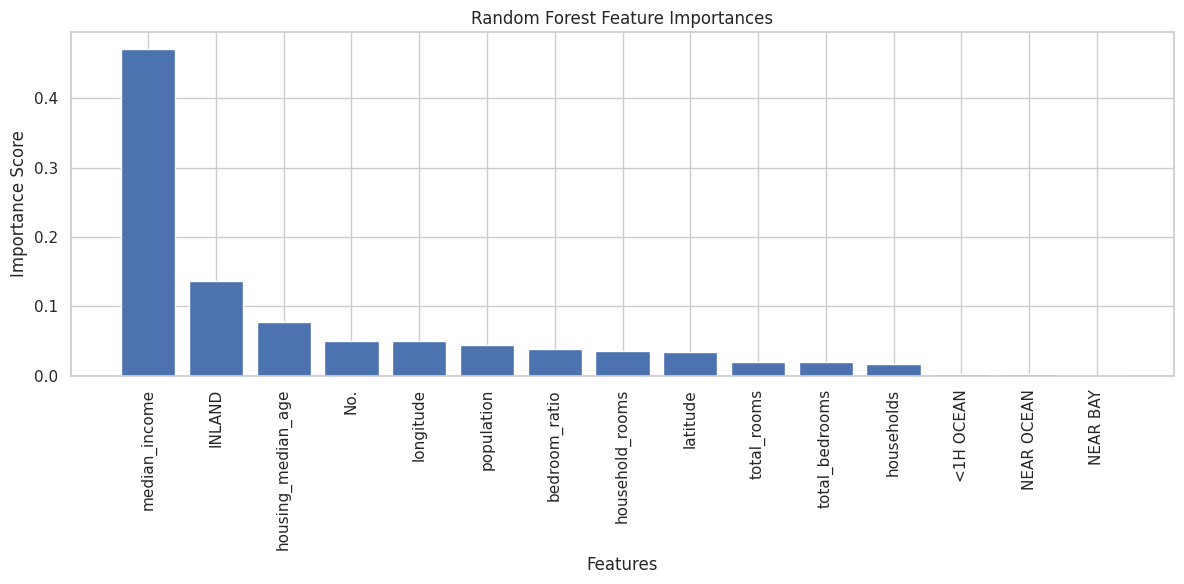

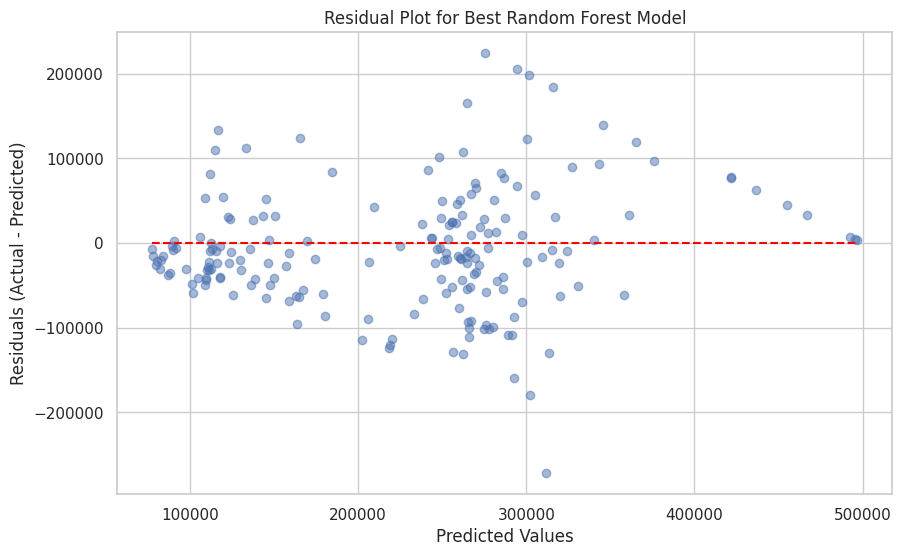


Final Evaluation Metrics (Best Random Forest):
MSE: 5072647392.50
RMSE: 71222.52
R² Score: 0.67


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
sns.set(style="whitegrid")

# 3. DATA LOADING & INITIAL EXPLORATION

# Read the CSV file (update the path as needed)
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/COMP1816_Housing_Dataset_Regression.csv")

# Check for null values in each column and overall
null_counts = df.isnull().sum()
print("Null values per column:\n", null_counts)

total_nulls = df.isnull().sum().sum()
print(f"\nTotal number of null values: {total_nulls}")

# Display rows with any null values
print("\nRows with null values:")
print(df[df.isnull().any(axis=1)])

# Drop rows with null values and display dataframe info
df.dropna(inplace=True)
df.info()


# 4. DATA SPLITTING

# Separate features and target variable
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

# Split data into train and test sets (using last 190 samples for testing)
X_train, X_test = X.iloc[:-190], X.iloc[-190:]
y_train, y_test = y.iloc[:-190], y.iloc[-190:]

# Combine X and y for training set for easier preprocessing
train_data = pd.concat([X_train, y_train], axis=1)


# 5. EXPLORATORY DATA ANALYSIS (EDA)

# Plot histogram for training data
plt.figure(figsize=(15, 9))
train_data.hist(bins=50, figsize=(15, 9))
plt.tight_layout()
plt.show()

# Calculate and plot correlation heatmap for numerical features
numerical_features = train_data.select_dtypes(include=['number'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Training Data)")
plt.show()

# Scatter plot for geographic distribution colored by median house value
plt.figure(figsize=(15, 9))
sns.scatterplot(x='longitude', y='latitude', hue='median_house_value', data=train_data, palette='coolwarm')
plt.title("Geographic Scatter Plot")
plt.show()

# 6. DATA PREPROCESSING & FEATURE ENGINEERING

# --- Preprocessing for Training Data ---
# Log-transform selected numerical features (add 1 to avoid log(0))
for col in ['total_rooms', 'total_bedrooms', 'population', 'households']:
    train_data[col] = np.log(train_data[col] + 1)

# Check the distribution of 'ocean_proximity'
print("\nOcean Proximity Value Counts (Training):")
print(train_data['ocean_proximity'].value_counts())

# Convert categorical feature 'ocean_proximity' to dummy variables
train_data = train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

# Create new features
train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['household_rooms'] = train_data['total_rooms'] / train_data['households']

# Plot updated correlation heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap with Engineered Features (Training Data)")
plt.show()


# 7. PREPARE DATA FOR MODELING

# Separate features and target from training data
X_train_proc = train_data.drop(['median_house_value'], axis=1)
y_train_proc = train_data['median_house_value']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_proc)

# 8. TRAIN A LINEAR REGRESSION MODEL

reg = LinearRegression()
reg.fit(X_train_scaled, y_train_proc)


# 9. PREPROCESS THE TEST DATA

# Combine test features and target for preprocessing
test_data = X_test.join(y_test)

# Apply log transformation to numerical features
for col in ['total_rooms', 'total_bedrooms', 'population', 'households']:
    test_data[col] = np.log(test_data[col] + 1)

# Convert categorical 'ocean_proximity' to dummy variables
test_data = test_data.join(pd.get_dummies(test_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

# Create new features for test data
test_data['bedroom_ratio'] = test_data['total_bedrooms'] / test_data['total_rooms']
test_data['household_rooms'] = test_data['total_rooms'] / test_data['households']

# Ensure the test data has the same feature columns as training data
X_test_proc = test_data.reindex(columns=X_train_proc.columns, fill_value=0)
y_test_proc = test_data['median_house_value']

# Scale test features using the same scaler as training data
X_test_scaled = scaler.transform(X_test_proc)


# 10. EVALUATE THE LINEAR REGRESSION MODEL

y_pred_lr = reg.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test_proc, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test_proc, y_pred_lr)

print("\nLinear Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"R-squared (R²): {r2_lr:.2f}")


# 11. TRAIN A RANDOM FOREST MODEL (Directly on Test Data for Demo)

forest = RandomForestRegressor()
forest.fit(X_test_scaled, y_test_proc)


# 12. GRID SEARCH FOR RANDOM FOREST HYPERPARAMETERS

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [2, 4, 6, 8],
    'min_samples_split': [2, 4],
    'max_depth': [None, 4, 8]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_scaled, y_train_proc)

best_rf = grid_search.best_estimator_
print("\nGrid Search Best Estimator (Random Forest):")
print(best_rf)
print(f"Test Score (R²): {best_rf.score(X_test_scaled, y_test_proc):.2f}")


# 13. MODEL COMPARISON: DECISION TREE, RANDOM FOREST, GRADIENT BOOSTING

# Define models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train_proc)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "MSE": mean_squared_error(y_test_proc, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test_proc, y_pred)),
        "R²": r2_score(y_test_proc, y_pred)
    }

print("\nModel Comparison:")
print("{:<20} {:<10} {:<10} {:<10}".format('Model', 'MSE', 'RMSE', 'R²'))
for model_name, metrics in results.items():
    print("{:<20} {:<10.2f} {:<10.2f} {:<10.2f}".format(
        model_name, metrics['MSE'], metrics['RMSE'], metrics['R²']
    ))

# Print Linear Regression results for reference
print("\nLinear Regression Reference:")
print("{:<20} {:<10.2f} {:<10.2f} {:<10.2f}".format(
    "Linear Regression", mse_lr, rmse_lr, r2_lr
))


# 14. FINAL HYPERPARAMETER TUNING & EVALUATION WITH RANDOM FOREST

# Definining a simpler parameter grid for final tuning
param_grid_final = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search_final = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_final,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_final.fit(X_train_scaled, y_train_proc)
best_model = grid_search_final.best_estimator_

print("\nFinal Grid Search Best Parameters:")
print(grid_search_final.best_params_)
print(f"Best RMSE (Training CV): {np.sqrt(-grid_search_final.best_score_):.2f}")

# Feature Importance
importances = best_model.feature_importances_
feature_names = X_train_proc.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_names)), importances[sorted_idx], align='center')
plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

#Residual Analysis
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test_proc - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred_best.min(), xmax=y_pred_best.max(), colors='red', linestyles='--')
plt.title("Residual Plot for Best Random Forest Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

#Final Evaluation
mse_final = mean_squared_error(y_test_proc, y_pred_best)
rmse_final = np.sqrt(mse_final)
r2_final = best_model.score(X_test_scaled, y_test_proc)

print("\nFinal Evaluation Metrics (Best Random Forest):")
print(f"MSE: {mse_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")
print(f"R² Score: {r2_final:.2f}")
